In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

from sktime.clustering.k_means import TimeSeriesKMeans
from sklearn.cluster import DBSCAN
from tslearn.clustering import silhouette_score
from sklearn.metrics import silhouette_score as silhouette_score_sklearn


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sktime.transformations.series.summarize import SummaryTransformer

In [16]:
df = pd.read_csv('./dataset_preprocessed/time_series/time_series.csv')

In [17]:
X = df.drop(columns=['genre']).values
y = df['genre'].values

In [18]:
scaler = TabularToSeriesAdaptor(StandardScaler(), fit_in_transform=True)
X_scaled = scaler.fit_transform(X)

# Distance Based Clustering

In [19]:
#%%time

#X = np.reshape(X,(10000, 1, 100)) #????
#dist = DtwDistTslearn(n_jobs=-1)
#dist_mat = dist.transform(X)

#np.save('./dataset_preprocessed/time_series/distance_matrix.npy', dist_mat)

In [8]:
dist_mat = np.load('./dataset_preprocessed/time_series/distance_matrix.npy')

In [ ]:
%%time
sse_list=[]
sil_list=[]
distance_params={'window':0.05}

for k in range(2, 17):
    print(f'Calculating {k}-means...')
    kmeans = TimeSeriesKMeans(n_clusters=k, metric='dtw', distance_params=distance_params, n_init=1, max_iter=500)
    kmeans.set_config(**{'backend:parallel': 'loky', 'n_jobs': -1})
    kmeans.fit(X_scaled)

    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(dist_mat, kmeans.labels_, metric='precomputed'))

In [9]:
#np.save('./dataset_preprocessed/time_series/sse_list.npy', sse_list)
#np.save('./dataset_preprocessed/time_series/silhouette_list.npy', sil_list)

In [39]:
sse_list = np.load('./dataset_preprocessed/time_series/sse_list.npy')
sil_list = np.load('./dataset_preprocessed/time_series/silhouette_list.npy')

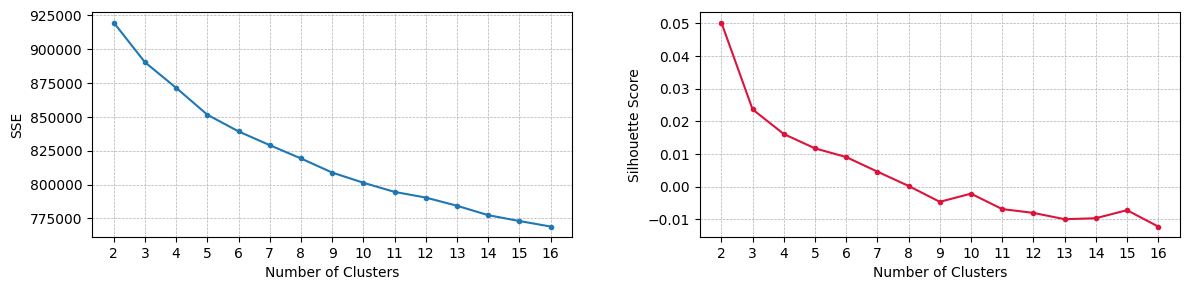

In [61]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))


# Plot sse_list in the first subplot
ax1.plot(range(2, 17), sse_list, marker='.')
ax1.set_xlabel('Number of Clusters')
ax1.set_xticks(np.arange(2, 17, 1))
ax1.set_ylabel('SSE')
ax1.grid(linestyle='--', linewidth=0.5)

# Plot sil_list in the second subplot
ax2.plot(range(2, 17), sil_list, marker='.', color='crimson')
ax2.set_xlabel('Number of Clusters')
ax2.set_xticks(np.arange(2, 17, 1))
ax2.set_ylabel('Silhouette Score')
ax2.grid(linestyle='--', linewidth=0.5)

# Adjust the spacing between subplots
plt.tight_layout(w_pad=4)

# Show the plot
plt.savefig('./img/TS Clustering/sse_silhouette.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
k = 5

In [6]:
kmeans = TimeSeriesKMeans(n_clusters=k, metric='dtw', distance_params={'window':0.05}, n_init=1, max_iter=500)
kmeans.fit(X_scaled)

TimeSeriesKMeans(distance_params={'window': 0.05}, max_iter=500, n_clusters=5,
                 n_init=1)

In [9]:
sse = kmeans.inertia_
silhouette = silhouette_score(dist_mat, kmeans.labels_, metric='precomputed')

print("SSE:", sse)
print("Silhouette Score:", silhouette)

SSE: 853964.9264752594
Silhouette Score: 0.011738002047580314


## Visualization

#### PCA

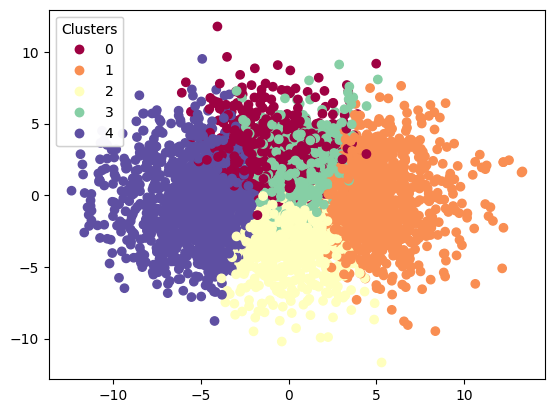

In [64]:
pca = PCA(n_components=2) 
pca_data = pd.DataFrame(pca.fit_transform(X_scaled),columns=['PC1','PC2'])
pca_data['cluster'] = pd.Categorical(kmeans.labels_)

fig = plt.figure()
ax = fig.add_subplot()

scatter = ax.scatter(pca_data['PC1'],
                     pca_data['PC2'],
                     c=pca_data['cluster'],
                     cmap='Spectral')

ax.add_artist(ax.legend(*scatter.legend_elements(),
                        loc="upper left",
                        title="Clusters"))

plt.savefig('img/TS Clustering/distance_based_PCA.png', dpi=300, bbox_inches='tight')

plt.show()

#### t-SNE

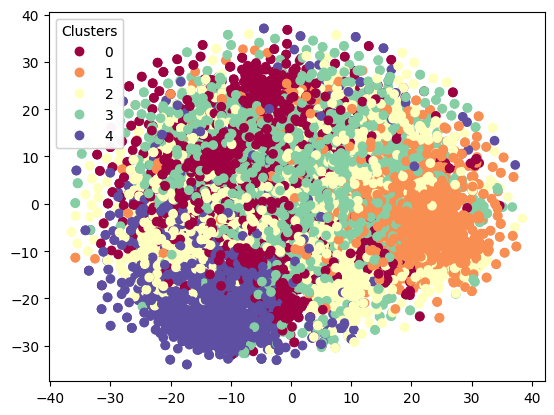

In [65]:
tsne = TSNE(n_components=2)
tsne_data = pd.DataFrame(tsne.fit_transform(X_scaled), columns=['D1', 'D2'])
tsne_data['cluster'] = pd.Categorical(kmeans.labels_)

fig = plt.figure()
ax = fig.add_subplot()

scatter = ax.scatter(tsne_data['D1'],
                     tsne_data['D2'],
                     c=tsne_data['cluster'],
                     cmap='Spectral')

ax.add_artist(ax.legend(*scatter.legend_elements(),
                        loc="upper left",
                        title="Clusters"))

plt.savefig('img/TS Clustering/distance_based_TSNE.png', dpi=300, bbox_inches='tight')

plt.show()

## Cluster Analysis

In [66]:
df['kmeans_labels'] = kmeans.labels_

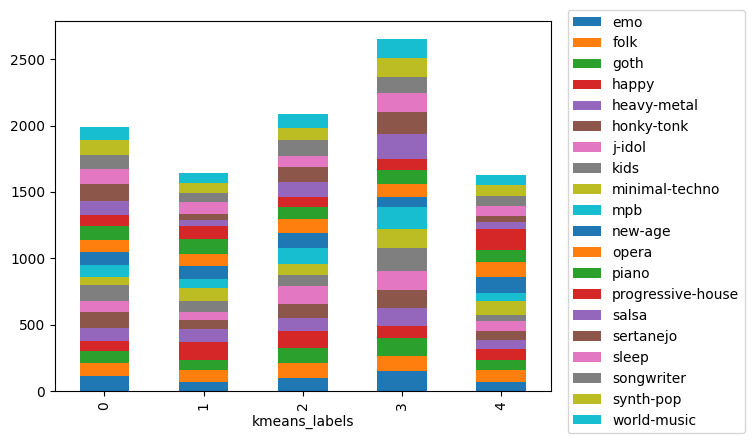

In [67]:
df.groupby('kmeans_labels')['genre'].value_counts().unstack().plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1.02, 1.05))

plt.savefig('./img/TS Clustering/distance_based_genre_distribution.png', dpi=300, bbox_inches='tight')

plt.show()

# Feature Based Clustering

In [20]:
transformer = SummaryTransformer()

In [21]:
X_reshaped = np.reshape(X, (10000,1,100))

In [22]:
X_features = transformer.fit_transform(X_reshaped)
X_features

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
instances,,,,,,,,,
0,1.010303e-16,0.896679,-1.599850,2.876452,-1.291127,-0.714730,0.185937,0.655687,0.930469
1,8.243406e-17,0.545201,-0.675401,2.764990,-0.569447,-0.403147,-0.047889,0.259557,0.587744
2,-3.774758e-17,0.708795,-1.734124,1.952544,-0.871337,-0.351428,-0.065724,0.333919,0.987408
3,-2.287059e-16,0.967123,-2.255452,1.806936,-1.363673,-0.756302,0.089570,0.755121,1.250336
4,9.436896e-17,0.450064,-1.075094,1.164657,-0.539670,-0.259648,-0.039615,0.364958,0.535408
...,...,...,...,...,...,...,...,...,...
9995,5.723200e-16,0.455611,-1.068876,1.333413,-0.583402,-0.303257,-0.020479,0.294849,0.549237
9996,-1.373901e-16,0.651049,-1.508941,1.744989,-0.649850,-0.381830,-0.120915,0.417477,0.886716
9997,2.198242e-16,0.803444,-2.250913,1.814268,-0.951195,-0.458055,-0.054226,0.453441,0.925038


In [23]:
from sklearn.neighbors import NearestNeighbors

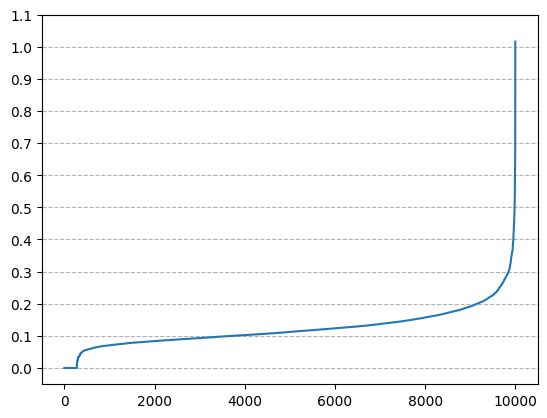

In [9]:
# Finding optimal Eps
for minpts in [16]:
    neighbors = NearestNeighbors(n_neighbors=minpts)
    neighbors_fit = neighbors.fit(X_features)
    
    dist, idx = neighbors_fit.kneighbors(X_features)
    
    dist = np.sort(dist, axis=0) 
    
    plt.plot(dist[:,1])    
    plt.yticks(np.arange(0, 1.2, step=0.1))
    plt.grid(axis='y', linestyle='--')

plt.savefig('img/TS Clustering/dbscan_optimal_eps.png', dpi=300, bbox_inches='tight')

plt.show()

In [24]:
eps = 0.25

In [35]:
sil_list=[]

for minpts in [2,4,8,16,32,64,128,256,512,1024]:
    dbscan = DBSCAN(eps=eps, min_samples=minpts, metric='euclidean')
    dbscan.fit(X_features)
    
    try:
        # Calculating silhouette score for all non-noise points
        sil = silhouette_score_sklearn(X_features[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1])
        sil_list.append(sil)
    except:
        print('No clusters for', minpts)

No clusters for 8
No clusters for 32
No clusters for 64
No clusters for 128
No clusters for 256
No clusters for 512
No clusters for 1024


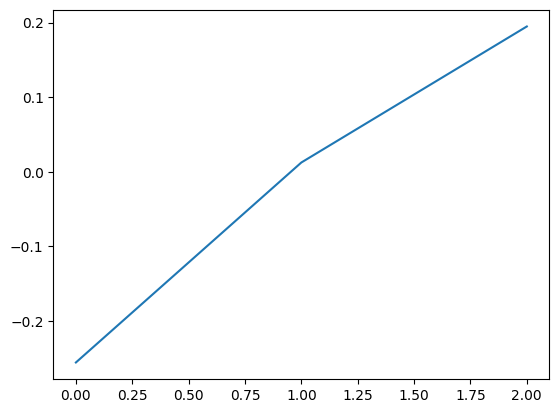

In [38]:
plt.plot(sil_list)
plt.show()

In [25]:
minpts = 16

In [26]:
dbscan = DBSCAN(eps=eps, min_samples=minpts, metric='euclidean')
dbscan.fit(X_features)

DBSCAN(eps=0.25, min_samples=16)

In [28]:
silhouette = silhouette_score_sklearn(X_features[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1])
print("Silhouette Score:", silhouette)

Silhouette Score: 0.1948400637581604


In [47]:
for i in np.unique(dbscan.labels_):
    print(X[dbscan.labels_ == i].shape, i)


(1161, 100) -1
(8786, 100) 0
(23, 100) 1
(14, 100) 2
(16, 100) 3


## Visualization

#### PCA

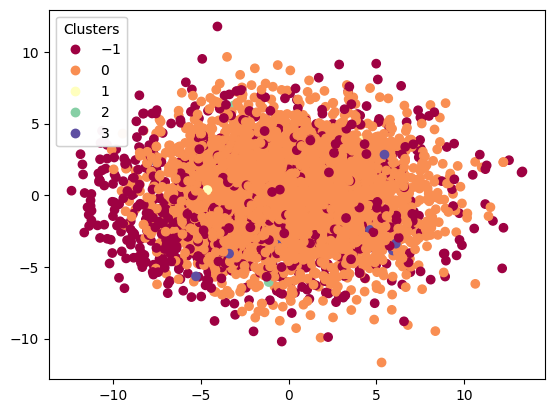

In [32]:
pca = PCA(n_components=2)
pca_data = pd.DataFrame(pca.fit_transform(X_scaled), columns=['PC1', 'PC2'])
pca_data['cluster'] = pd.Categorical(dbscan.labels_)

fig = plt.figure()
ax = fig.add_subplot()

scatter = ax.scatter(pca_data['PC1'],
                     pca_data['PC2'],
                     c=pca_data['cluster'],
                     cmap='Spectral')

ax.add_artist(ax.legend(*scatter.legend_elements(),
                        loc="upper left",
                        title="Clusters"))

plt.savefig('img/TS Clustering/feature_based_PCA.png', dpi=300, bbox_inches='tight')

plt.show()

#### t-SNE

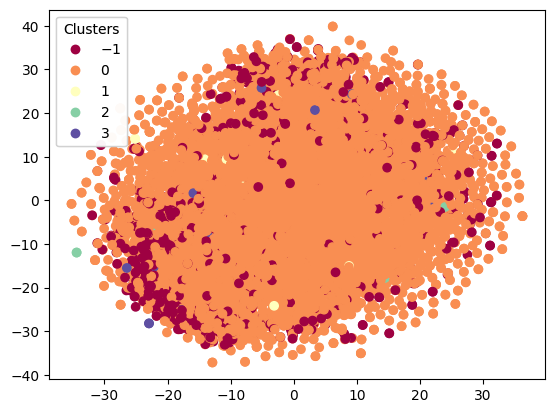

In [33]:
tsne = TSNE(n_components=2)
tsne_data = pd.DataFrame(tsne.fit_transform(X_scaled), columns=['D1', 'D2'])
tsne_data['cluster'] = pd.Categorical(dbscan.labels_)

fig = plt.figure()
ax = fig.add_subplot()

scatter = ax.scatter(tsne_data['D1'],
                     tsne_data['D2'],
                     c=tsne_data['cluster'],
                     cmap='Spectral')

ax.add_artist(ax.legend(*scatter.legend_elements(),
                        loc="upper left",
                        title="Clusters"))

plt.savefig('img/TS Clustering/feature_based_TSNE.png', dpi=300, bbox_inches='tight')

plt.show()

## Cluster Analysis

In [45]:
df['dbscan_labels'] = dbscan.labels_

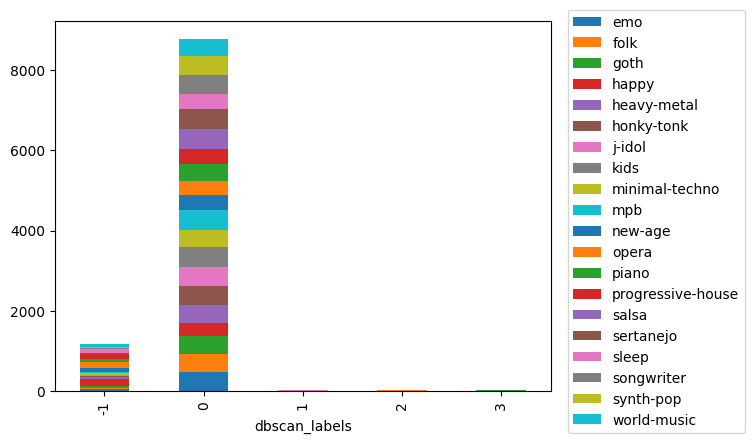

In [25]:
df.groupby('dbscan_labels')['genre'].value_counts().unstack().plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1.02, 1.05))

plt.savefig('img/TS Clustering/feature_based_genre_distribution.png', dpi=300, bbox_inches='tight')

plt.show()